In [6]:
# pip import tensorflow keras sklearn matplotlib pillow opencv-python

import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,  AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10155663186694323497
xla_global_id: -1
]


In [7]:
fpath = "./input/stanford-dogs-dataset/images/Images/"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound'] 

No. of categories =  20


In [8]:
import xml.etree.ElementTree as ET
def getBBox(category,image_name):
    root = ET.parse('input/stanford-dogs-dataset/annotations/Annotation/'+category+'/'+image_name).getroot()
    for type_tag in root.findall('object/bndbox'):
        xmin = int(type_tag.findtext('xmin'))
        ymin = int(type_tag.findtext('ymin'))
        xmax = int(type_tag.findtext('xmax'))
        ymax = int(type_tag.findtext('ymax'))
    return [xmin,ymin,xmax,ymax]

In [32]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    images_cropped = 0
    image_crop_comparisson = []
    example_saved = False

    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            box = getBBox(category, image_name[:-3]) #[:-3] to remove .jpg from image filename
            box_width = box[2] - box[0]
            box_height = box[3] - box[1]
            image_width = img_array.width
            image_height = img_array.height
            box_aspect = box_width/box_height
            image_aspect = image_width/image_height
            resized_img = img_array
            if abs(1-box_aspect) < abs(1-image_aspect):
                # Box aspect is closer to 1:1 (square)
                # Therefore we crop to the dog, and resize based on that
                cropped_img = img_array.crop(box=box)
                resized_img = cropped_img.resize((244,244))
                images_cropped += 1
                if example_saved == False:
                    example_saved = True
                    image_crop_comparisson.append(np.array(img_array))                    #original
                    image_crop_comparisson.append(np.array(img_array.resize((244,244))))  #original resized
                    image_crop_comparisson.append(np.array(cropped_img))                  #cropped
                    image_crop_comparisson.append(np.array(resized_img))                  #cropped resized
            else:
                # Box aspect is closer to 1:1 (square)
                resized_img = img_array.resize((244,244))


            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels, images_cropped, image_crop_comparisson

images, labels, images_cropped, image_crop_comparisson = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))
print("No. of images cropped: ", images_cropped)
images = np.array(images)
labels = np.array(labels)


No. of images loaded =  3633 
No. of labels loaded =  3633
<class 'list'> <class 'list'>
No. of images cropped:  1969


In [33]:
images = np.array(images)
labels = np.array(labels)
image_crop_comparisson = np.array(image_crop_comparisson)
image_crop_comparisson_labels = np.array(['Original','Resized','Cropped','Cropped + Resized'])

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels),type(image_crop_comparisson_labels))

['Original' 'Resized' 'Cropped' 'Cropped + Resized']
Images shape =  (3633, 244, 244, 3) 
Labels shape =  (3633,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


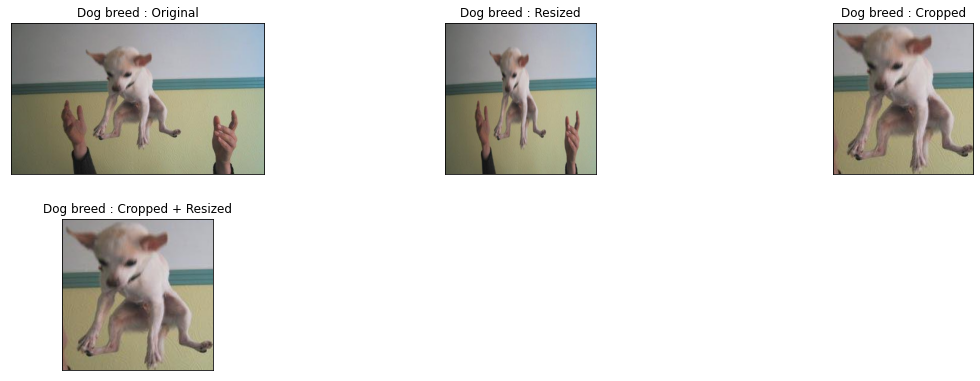

In [35]:
def display_cropped_image_example(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0
    for i in range(4):
        n += 1
        r = np.random.randint(0 , images.shape[0] , 1)

        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[i])

        plt.title('Dog breed : {}'.format(labels[i]))
        plt.xticks([])
        plt.yticks([])

    plt.show()
display_cropped_image_example(image_crop_comparisson, image_crop_comparisson_labels)

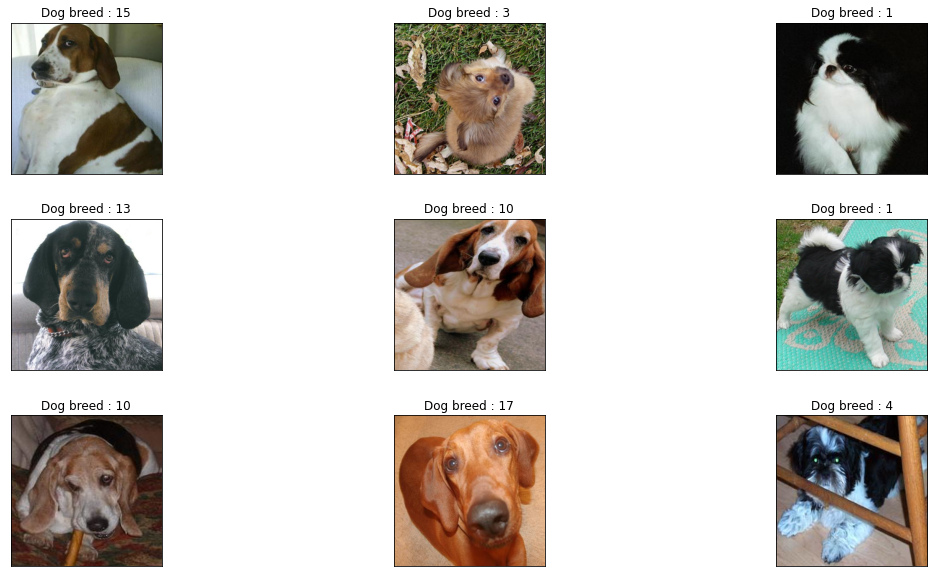

In [36]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0
    for i in range(9):
        n += 1
        r = np.random.randint(0 , images.shape[0] , 1)

        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])

        plt.title('Dog breed : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])

    plt.show()

display_rand_images(images, labels)


In [38]:
images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))
#images = images.reshape((images.shape[0],1))
#types_2class = np.zeros((images.shape[0],2))

from tensorflow.keras.utils import to_categorical
#label_output_matrix = to_categorical(labels, num_classes = 20, dtype ="int32")

# Split into training set and testing set
X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                random_state=48)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)
# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)


x_train shape =  (2179, 224, 224, 3)
y_train shape =  (2179, 20)

x_test shape =  (1454, 224, 224, 3)
y_test shape =  (1454,)


In [39]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(224,224,3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)


In [50]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12 #number of output feature maps per layer
classes = 20
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 224, 224, 24  648         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 activation_48 (Activation)     (None, 224, 224, 24  0           ['conv2d_45[0][0]']              
                                )                                                           

In [51]:
model.save('DenseNet-base.model')

INFO:tensorflow:Assets written to: DenseNet-base.model\assets


In [52]:
model.trainable = True
print("Number of layers in the base model: ", len(model.layers))
fine_tune_at = 50
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False
fine_tune_optimizer = Adam(lr=0.0001/10, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='binary_crossentropy',
              optimizer = fine_tune_optimizer,
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Number of layers in the base model:  76
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 224, 224, 24  648         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 activation_48 (Activation)     (None, 224, 224, 24  0           ['conv2d_45[0][0]']              
                                )                   

17

In [53]:
fine_tune_epochs = 5
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(X_train,y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(x_test, Cat_test_y))


Epoch 10/15
69/69 [==============================] - 104s 1s/step - loss: 0.1988 - accuracy: 0.0707 - val_loss: 0.2000 - val_accuracy: 0.0708

In [54]:
model.save('DenseNet-fineTuned.model')

INFO:tensorflow:Assets written to: DenseNet-fineTuned.model\assets


Generating plots...


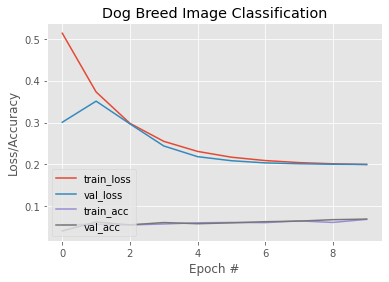

In [55]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
import sys
import matplotlib
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = epochs
matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Dog Breed Image Classification")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

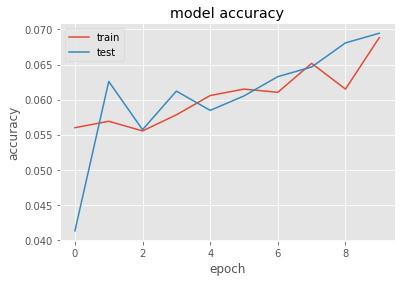

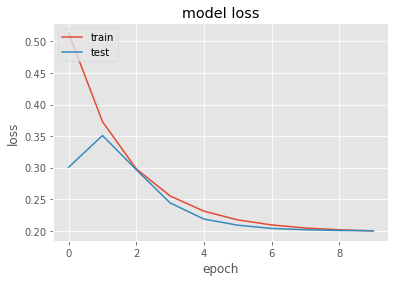

In [56]:
# plot model performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.figure()
plt.gcf().clear()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


TypeError: unsupported operand type(s) for -: 'list' and 'int'

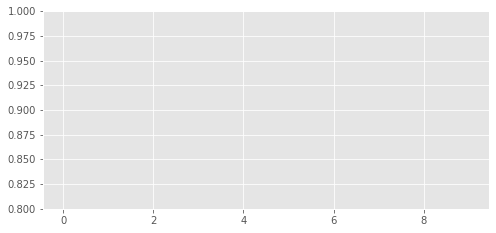

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([history.epoch-1,history.epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch-1,history.epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
from sklearn import metrics
label_pred = model.predict(x_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.00      0.00      0.00        71
           2       0.07      0.51      0.12        98
           3       0.00      0.00      0.00        46
           4       0.06      0.16      0.08        90
           5       0.00      0.00      0.00        74
           6       0.00      0.00      0.00        77
           7       0.00      0.00      0.00        69
           8       0.00      0.00      0.00        63
           9       0.07      0.31      0.12        96
          10       0.00      0.00      0.00        66
          11       0.00      0.00      0.00        80
          12       0.00      0.00      0.00        70
          13       0.00      0.00      0.00        75
          14       0.00      0.00      0.00        71
          15       0.00      0.00      0.00        65
          16       0.00      0.00      0.00        61
          17       0.00    

In [58]:
from sklearn import metrics
label_pred = model.predict(x_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(f"Accuracy Score: %{metrics.accuracy_score(Y_test, pred,normalize=False)}")

Accuracy Score: %96
